<a href="https://colab.research.google.com/github/BhagwatPriyanka/CE888-Assignment-1/blob/main/Project_3_CE888.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Is The UK Police Biased?**
   **(Bias in ML algorithms)**


In [139]:
#import libraries

import pandas as pd
import numpy as np
from datetime import datetime 
#data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#label encoder
from sklearn.preprocessing import LabelEncoder
#train-test-split and cross validation
from sklearn.model_selection import train_test_split, cross_val_score
#classifier
from sklearn.ensemble import RandomForestClassifier
#feature selection
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

figsize = (16,8)

Loading data:

**This dataset is obtained from https://data.police.uk/data/.  which contains records of search and stop objects, ethnicity and legislation in May 2019. The dataframe has 1369 observations and infomration on 15 variables.**

In [140]:
 df=pd.read_csv("https://raw.githubusercontent.com/BhagwatPriyanka/CE888/main/Project/2019-05-essex-stop-and-search.csv")
 df.head()

,Type,Date,Part of a policing operation,Policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing
0,Person and Vehicle search,2019-04-30T23:01:00+00:00,False,NaN,51.881266,0.253037,Female,over 34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Khat or Cannabis warning,True,False
1,Person and Vehicle search,2019-04-30T23:01:00+00:00,False,NaN,51.881266,0.253037,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False
2,Person search,2019-04-30T23:01:00+00:00,False,NaN,51.551467,0.651706,Male,Oct-17,White - English/Welsh/Scottish/Northern Irish/...,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,A no further action disposal,False,False
3,Person and Vehicle search,2019-05-01T00:01:00+00:00,True,NaN,51.712638,0.152202,Female,25-34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,True,False
4,Vehicle search,2019-05-01T01:01:00+00:00,False,NaN,51.581672,0.455687,NaN,NaN,NaN,NaN,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,NaN


In [141]:
#shape of the dataframe
df.shape

(1369, 15)

In [142]:
#checking for NaN values
df.isnull().sum()

Type                                           0
Date                                           0
Part of a policing operation                   0
Policing operation                          1369
Latitude                                      25
Longitude                                     25
Gender                                        97
Age range                                    115
Self-defined ethnicity                        97
Officer-defined ethnicity                    102
Legislation                                    0
Object of search                               0
Outcome                                       13
Outcome linked to object of search             0
Removal of more than just outer clothing      97
dtype: int64

In [143]:
#dropping columns with only NaN values
df.drop(columns = ["Policing operation"], axis = 1, inplace = True)

In [144]:
#dropping unnecessary columns 
df.drop(columns = ["Date","Latitude","Longitude"], axis = 1, inplace = True)

In [145]:
#columns names in the dataframe
df.columns

Index(['Type', 'Part of a policing operation', 'Gender', 'Age range',
       'Self-defined ethnicity', 'Officer-defined ethnicity', 'Legislation',
       'Object of search', 'Outcome', 'Outcome linked to object of search',
       'Removal of more than just outer clothing'],
      dtype='object')

In [146]:
df.shape

(1369, 11)

In [147]:
#dropping rows with missing values in 'Outcome' column
df = df[df["Outcome"].notna()]

**Data transformation and sensitive features:**

In [148]:
#Stops By Race
df["Officer-defined ethnicity"].value_counts()

White    1046
Black     130
Asian      44
Other      38
Name: Officer-defined ethnicity, dtype: int64

Testing for bias in data

Is the data imbalanced?

In [149]:
#Stops By Gender
df["Gender"].value_counts()

Male      1115
Female     148
Name: Gender, dtype: int64

In [150]:
df['Age range'].value_counts()

18-24      426
Oct-17     378
25-34      239
over 34    202
Name: Age range, dtype: int64

In [151]:
# Get indexes where 'Age range' column has value Oct-17
indexNames = df[(df['Age range'] == 'Oct-17')].index
indexNames
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

## **Pre Processing and Data visualization:**

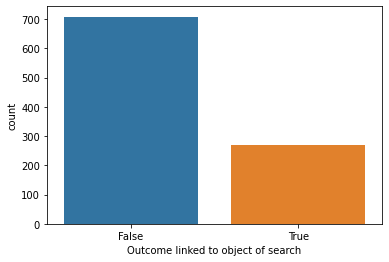

In [152]:
#racial distributions among the arrested subjects
sns.countplot(x="Outcome linked to object of search", data=df)

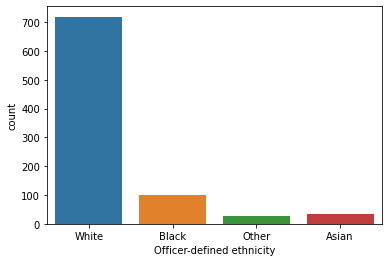

In [153]:
#Plot race wise
sns.countplot(x="Officer-defined ethnicity", data= df)

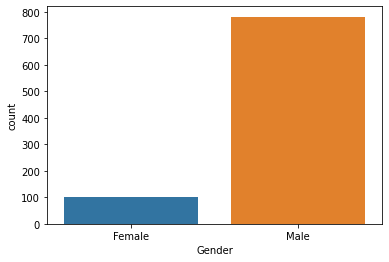

In [154]:
#Plot Gender wise
sns.countplot(x = "Gender", data = df)

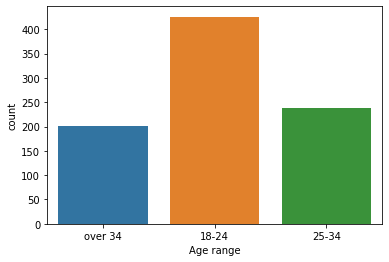

In [155]:
#Plot Age wise
sns.countplot(x = "Age range", data = df)

In [156]:
#helper function
def compute_outcome_stats(dfdf):
    """Compute statistics regarding the relative quanties of arrests, warnings, and citations"""
    n_total = len(dfdf)
    n_warnings = len(dfdf[dfdf['Outcome'] == 'Khat or Cannabis warning'])
    n_penalty = len(dfdf[dfdf['Outcome'] == 'Penalty Notice for Disorder'])
    n_arrests = len(dfdf[dfdf['Outcome'] == 'Arrest'])
    penalty_per_warning = n_penalty / n_warnings
    arrest_rate = n_arrests / n_total

    return(pd.Series(data = {
        'n_total': n_total,
        'n_warnings': n_warnings,
        'n_penalty': n_penalty,
        'n_arrests': n_arrests,
        'penalty_per_warning': penalty_per_warning,
        'arrest_rate': arrest_rate
    }))

In [157]:
compute_outcome_stats(df)

n_total                978.000000
n_warnings             119.000000
n_penalty                7.000000
n_arrests              140.000000
penalty_per_warning      0.058824
arrest_rate              0.143149
dtype: float64

In [158]:
#breakdown by gender (using helper function)
df.groupby('Gender').apply(compute_outcome_stats)

,n_total,n_warnings,n_penalty,n_arrests,penalty_per_warning,arrest_rate
Gender,,,,,,
Female,103.0,7.0,0.0,15.0,0.000000,0.145631
Male,782.0,104.0,7.0,114.0,0.067308,0.145780


In [159]:
#breakdown by race (using helper function)
df.groupby('Officer-defined ethnicity').apply(compute_outcome_stats)

,n_total,n_warnings,n_penalty,n_arrests,penalty_per_warning,arrest_rate
Officer-defined ethnicity,,,,,,
Asian,35.0,7.0,0.0,3.0,0.000000,0.085714
Black,100.0,12.0,1.0,10.0,0.083333,0.100000
Other,26.0,1.0,0.0,3.0,0.000000,0.115385
White,719.0,91.0,6.0,113.0,0.065934,0.157163


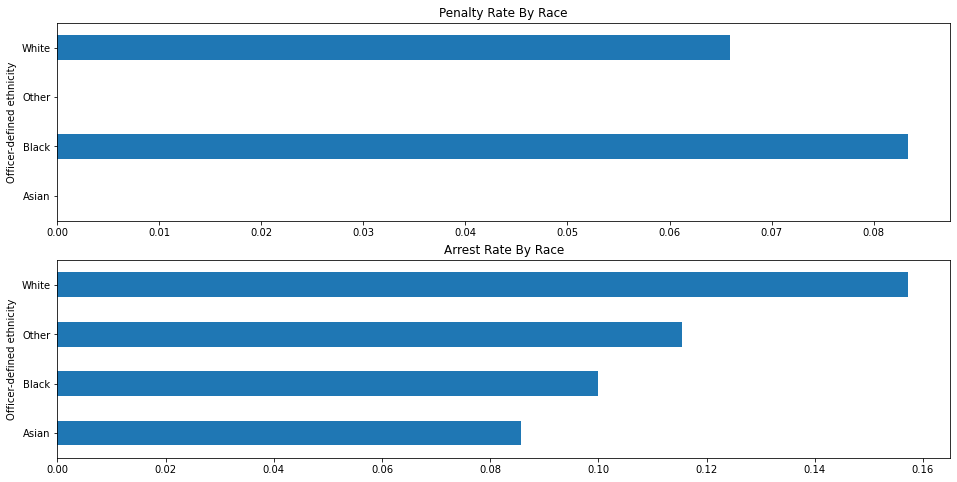

In [160]:
#penalty rate and arrest rate by race
race_agg = df.groupby(['Officer-defined ethnicity']).apply(compute_outcome_stats)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=figsize)
race_agg['penalty_per_warning'].plot.barh(ax=axes[0], figsize=figsize, title="Penalty Rate By Race")
race_agg['arrest_rate'].plot.barh(ax=axes[1], figsize=figsize, title='Arrest Rate By Race')

In [161]:
#target column
y = df["Outcome linked to object of search"]

Objective:

We want to train a classification model to classify whether a subject stopped and searched is arrested or not. The objective is to analyze whether sensitive features like gender and race of the subject determines the outcome, arrest or no arrest.

The target/outcome variable is given by "Outcome linked to object of search" column in the dataset.

We will initially select important attributes about subject like gender, race, age, search as the input variables to train the model.

Further, feature selection methods like Recursive Feature Elimination and GridSearchCV in scikit-learn will be used to find the important features for model training and performance.

Sensitive features:

In [162]:
#Racial bias
privileged_group = df[df["Officer-defined ethnicity"] == "Whites"]
underprivileged_group = df[df["Officer-defined ethnicity"] == "Non-Whites"]

In [163]:
#gender bias
privileged_group = df[df["Gender"] == "FEMALE"]
underprivileged_group = df[df["Gender"] == "MALE"]